In this notebook we naively embedd the Q-matrix for QUBO problems in a register through the $C_6/R_{ij}$ interactions.   
This almost never works well.

# CLIQUE

The problem is maximum clique, i.e. find the largest clique in the graph
First, we need to convert the problem to a QUBO
We follow the approach in Lucas et al. 2014

First, we define the problem as a binary optimization problem
We have a binary variable for each node in the graph
The Hamiltonian is:
$$ H_\text{MC} = -A \sum_{v\in V} x_v + B \sum_{(u, v) \in \bar{E}} x_u x_v $$

$x_v$ is 1 if the vertex belongs to the clique and 0 if not.

$H(t) = \sum_i \frac{\hbar}{2} \Omega_i(t) \sigma_i^x - \sum_i \delta_i(t) \hbar \hat{n}_i + \sum_{j<i} \frac{C_6}{R_{ij}^6} \hat{n}_i \hat{n}_j$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx import gnm_random_graph
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

from qubovert.utils import solve_qubo_bruteforce as qubo_solver


import pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice, MockDevice  
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform

import sys
sys.path.append('..')

from source.qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from source.qubovert_custom import problem_to_qubo_matrix
from source.helpers import matprint
from itertools import combinations


In [2]:
# x.T @ Q @ x

def max_clique_qubo(graph, A=1.0, B=2.0):
    nodes = list(graph.nodes)
    N = len(nodes)
    Q = np.zeros((N, N))
    edges = list(graph.edges)
    
    # Set diagonal terms: -A * x_i
    for i in range(N):
        Q[i, i] = -A
    
    # Build the complement edge set
    all_pairs = combinations(nodes, 2)
    for i, j in all_pairs:
        if (i, j) not in edges and (j, i) not in edges:
            Q[i, j] = B
            Q[j, i] = B
    
    return Q

In [3]:
graph = gnm_random_graph(8, 14, seed=1337)
Q = max_clique_qubo(graph, A=1.0, B=2.0)
Q

array([[-1.,  0.,  2.,  0.,  0.,  2.,  0.,  2.],
       [ 0., -1.,  2.,  0.,  2.,  0.,  2.,  2.],
       [ 2.,  2., -1.,  2.,  2.,  0.,  2.,  2.],
       [ 0.,  0.,  2., -1.,  0.,  2.,  0.,  0.],
       [ 0.,  2.,  2.,  0., -1.,  0.,  2.,  0.],
       [ 2.,  0.,  0.,  2.,  0., -1.,  0.,  0.],
       [ 0.,  2.,  2.,  0.,  2.,  0., -1.,  2.],
       [ 2.,  2.,  2.,  0.,  0.,  0.,  2., -1.]])

In [4]:
solutions = solve_qubo_bruteforce(Q, n=10) # my function, just tries all combinations
solutions

[(array([0, 0, 0, 0, 1, 1, 0, 1]), -3.0),
 (array([0, 0, 0, 1, 1, 0, 0, 1]), -3.0),
 (array([1, 0, 0, 1, 0, 0, 1, 0]), -3.0),
 (array([1, 0, 0, 1, 1, 0, 0, 0]), -3.0),
 (array([1, 1, 0, 1, 0, 0, 0, 0]), -3.0),
 (array([0, 0, 0, 0, 0, 1, 0, 1]), -2.0),
 (array([0, 0, 0, 0, 0, 1, 1, 0]), -2.0),
 (array([0, 0, 0, 0, 1, 0, 0, 1]), -2.0),
 (array([0, 0, 0, 0, 1, 1, 0, 0]), -2.0),
 (array([0, 0, 0, 1, 0, 0, 0, 1]), -2.0)]

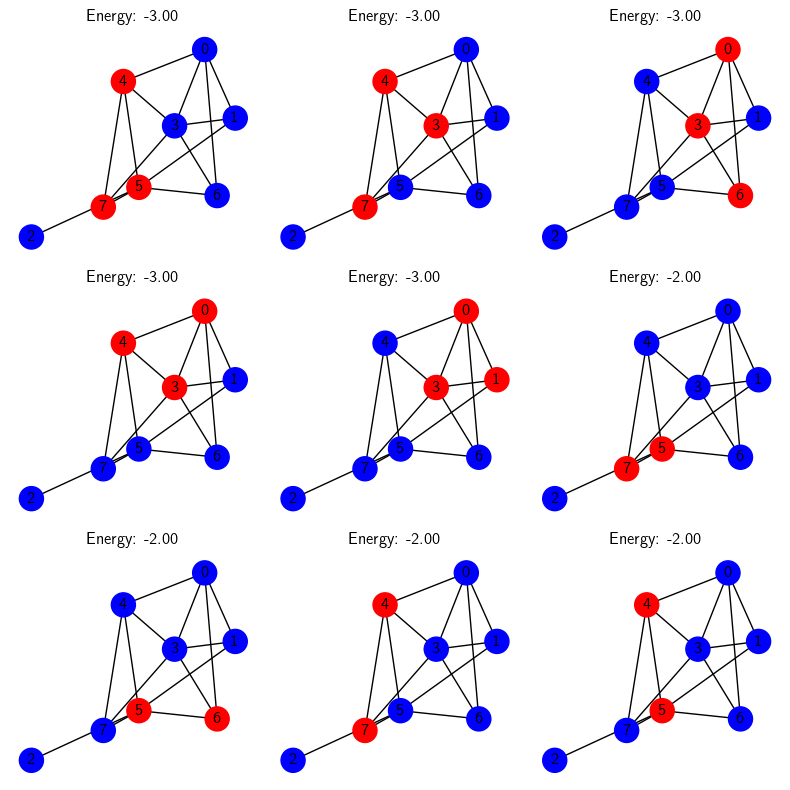

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
pos = nx.spring_layout(graph, seed=42)

for idx, s in enumerate(solutions[:9]):
    row = idx // 3
    col = idx % 3
    
    color_map = []
    for node in graph:
        if s[0][node] == 1:
            color_map.append('red')
        else:
            color_map.append('blue')
            
    nx.draw(graph, node_color=color_map, with_labels=True, 
            ax=axs[row, col], pos=pos)
    axs[row, col].set_title(f"Energy: {s[1]:.2f}")

plt.suptitle("Clique solutions (Brute-force)", fontsize=16)
plt.tight_layout()
plt.show()

/home/bigbogo/Documents/Projects/PulserLearn/QUBOExploration/../source/qubo.py:91: UserWarning: Relative differences between the QUBO matrix and the new matrix are too high: 1.9999949627126314
  warnings.warn(f"Relative differences between the QUBO matrix and the new matrix are too high: {np.max(rel_diff)}")
/home/bigbogo/Documents/Projects/PulserLearn/QUBOExploration/../source/qubo.py:92: UserWarning: rel_diff: 
[[0.00000000e+00 1.99699117e+00 2.00677398e-01 1.99986772e+00
  1.99999496e+00 8.94878834e-01 1.98949763e+00 1.98881868e+00]
 [1.99699117e+00 0.00000000e+00 1.99769258e+00 1.99943566e+00
  1.98308947e+00 1.99983164e+00 4.01338521e-05 4.04667725e-02]
 [2.00677398e-01 1.99769258e+00 0.00000000e+00 1.99043270e+00
  4.75117962e-11 1.99968201e+00 1.99889442e+00 1.99374108e+00]
 [1.99986772e+00 1.99943566e+00 1.99043270e+00 0.00000000e+00
  1.99942644e+00 8.44235751e-04 1.99499481e+00 1.99845936e+00]
 [1.99999496e+00 1.98308947e+00 4.75117962e-11 1.99942644e+00
  0.00000000e+00 1.99

Pulse integral: 1.59979999017


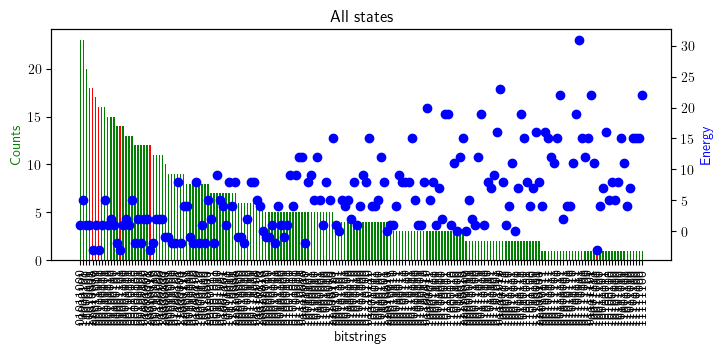

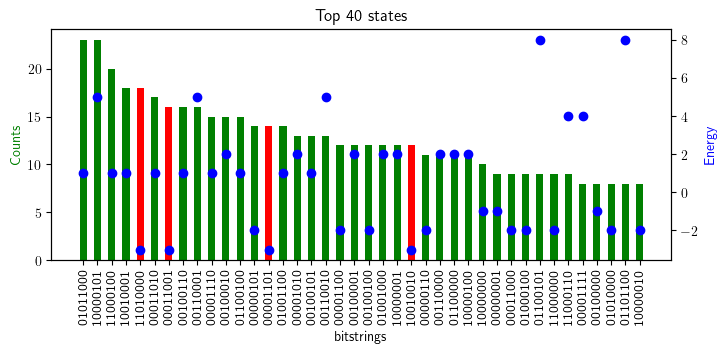

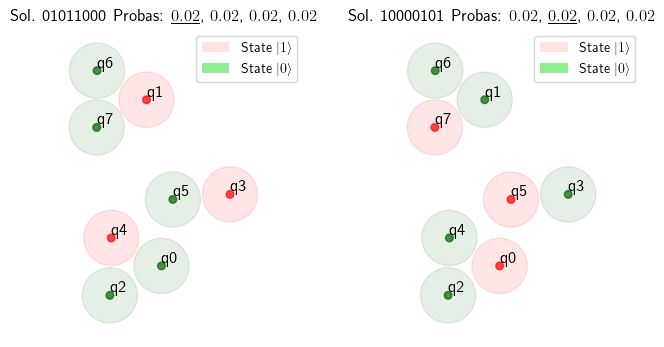

In [6]:
# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 2.5
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=False)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
Omega = 0.3
delta_i = -1.0 
delta_f = -delta_i
T = 8_000  # time in ns
count_dict = anneal(reg, Omega, delta_i, delta_f, T, device=MockDevice)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:5]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=None)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.title("All states")
plt.show()

plot_distribution(count_dict, solutions_strs, show=False, n_max_states=40)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:40], res_vals[:40], c="blue")
plt.title("Top 40 states")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True)

Let's investigate the embedding:

In [7]:
Q

array([[-1.,  0.,  2.,  0.,  0.,  2.,  0.,  2.],
       [ 0., -1.,  2.,  0.,  2.,  0.,  2.,  2.],
       [ 2.,  2., -1.,  2.,  2.,  0.,  2.,  2.],
       [ 0.,  0.,  2., -1.,  0.,  2.,  0.,  0.],
       [ 0.,  2.,  2.,  0., -1.,  0.,  2.,  0.],
       [ 2.,  0.,  0.,  2.,  0., -1.,  0.,  0.],
       [ 0.,  2.,  2.,  0.,  2.,  0., -1.,  2.],
       [ 2.,  2.,  2.,  0.,  0.,  0.,  2., -1.]])

In [8]:
Q_embedding = get_Q_from_coords(coords)
Q_embedding

array([[0.00000000e+00, 1.32741967e-03, 6.54097544e-01, 3.02376248e-02,
        7.94076183e-01, 3.05399705e-01, 3.78866258e-04, 2.24153607e-03],
       [1.32741967e-03, 0.00000000e+00, 4.60750775e-04, 7.08593454e-03,
        3.39546953e-03, 2.37562476e-02, 8.00032108e-01, 8.33042010e-01],
       [6.54097544e-01, 4.60750775e-04, 0.00000000e+00, 1.91705060e-03,
        8.00000000e-01, 1.25771845e-02, 2.20178404e-04, 1.25274679e-03],
       [3.02376248e-02, 7.08593454e-03, 1.91705060e-03, 0.00000000e+00,
        6.97204493e-03, 8.00675675e-01, 7.97170187e-04, 2.59432360e-03],
       [7.94076183e-01, 3.39546953e-03, 8.00000000e-01, 6.97204493e-03,
        0.00000000e+00, 1.94584865e-01, 1.27687666e-03, 1.48988703e-02],
       [3.05399705e-01, 2.37562476e-02, 1.25771845e-02, 8.00675675e-01,
        1.94584865e-01, 0.00000000e+00, 2.56556532e-03, 2.15355937e-02],
       [3.78866258e-04, 8.00032108e-01, 2.20178404e-04, 7.97170187e-04,
        1.27687666e-03, 2.56556532e-03, 0.00000000e+00, 8.

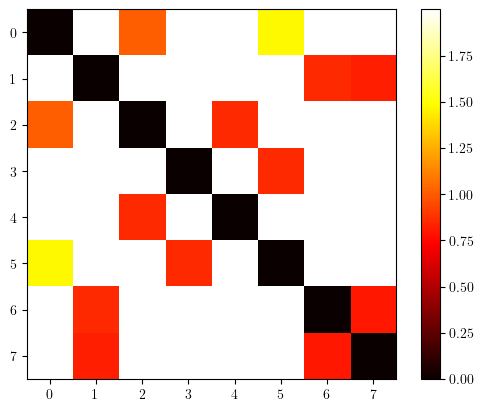

In [9]:
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff, cmap='hot', interpolation='nearest')
plt.colorbar()

The problem is that in 2D it is just not possible to encode the off-diagonal elements perfectly into the interactions $R_{ij}$.

## More Graphs

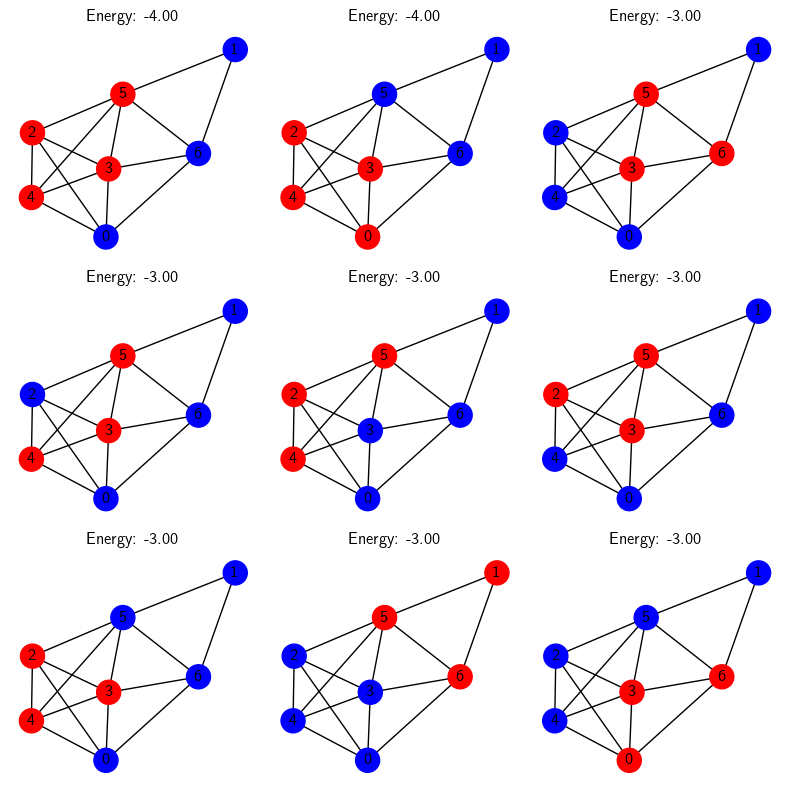

Pulse integral: 3.141143824905


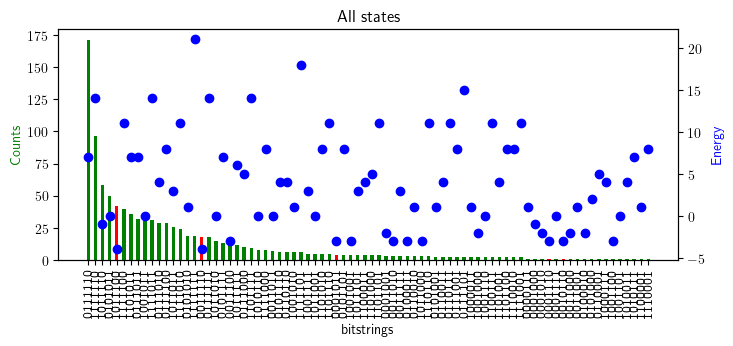

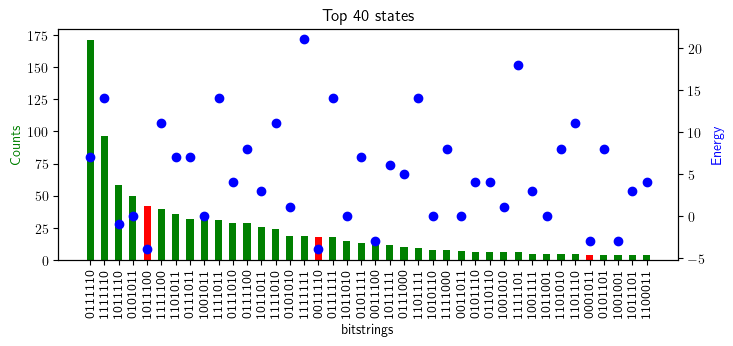

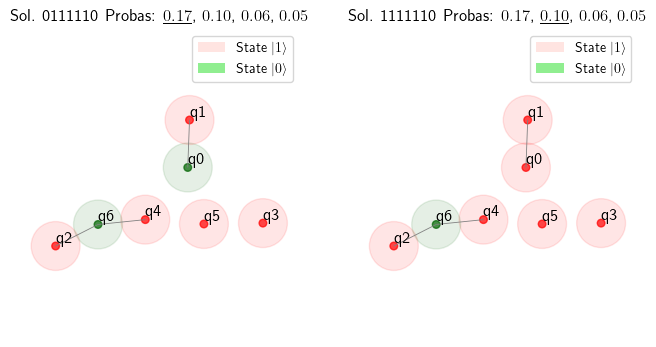

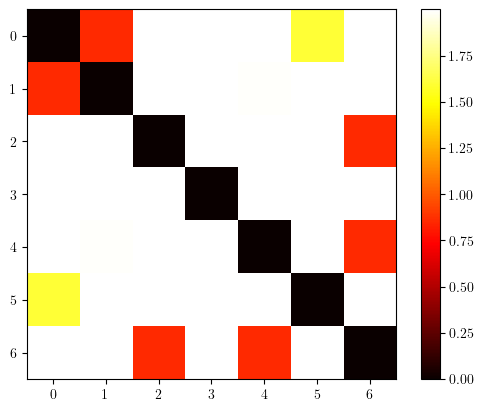

In [10]:
graph = gnm_random_graph(7, 14, seed=1337)
Q = max_clique_qubo(graph, A=1.0, B=2.0)
solutions = solve_qubo_bruteforce(Q, n=10) # my function, just tries all combinations

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
pos = nx.spring_layout(graph, seed=42)

for idx, s in enumerate(solutions[:9]):
    row = idx // 3
    col = idx % 3
    
    color_map = []
    for node in graph:
        if s[0][node] == 1:
            color_map.append('red')
        else:
            color_map.append('blue')
            
    nx.draw(graph, node_color=color_map, with_labels=True, 
            ax=axs[row, col], pos=pos)
    axs[row, col].set_title(f"Energy: {s[1]:.2f}")

plt.suptitle("Clique solutions (Brute-force)", fontsize=16)
plt.tight_layout()
plt.show()

# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 2.5
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=True)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
delta_i = -1.
delta_f = -delta_i
T = 7_000  # time in ns
Omega = 1.5 * np.pi * 1000. / T
count_dict = anneal(reg, Omega, delta_i, delta_f, T, device=MockDevice)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:5]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=None)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.title("All states")
plt.show()

plot_distribution(count_dict, solutions_strs, show=False, n_max_states=40)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:40], res_vals[:40], c="blue")
plt.title("Top 40 states")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff, cmap='hot', interpolation='nearest')
plt.colorbar()

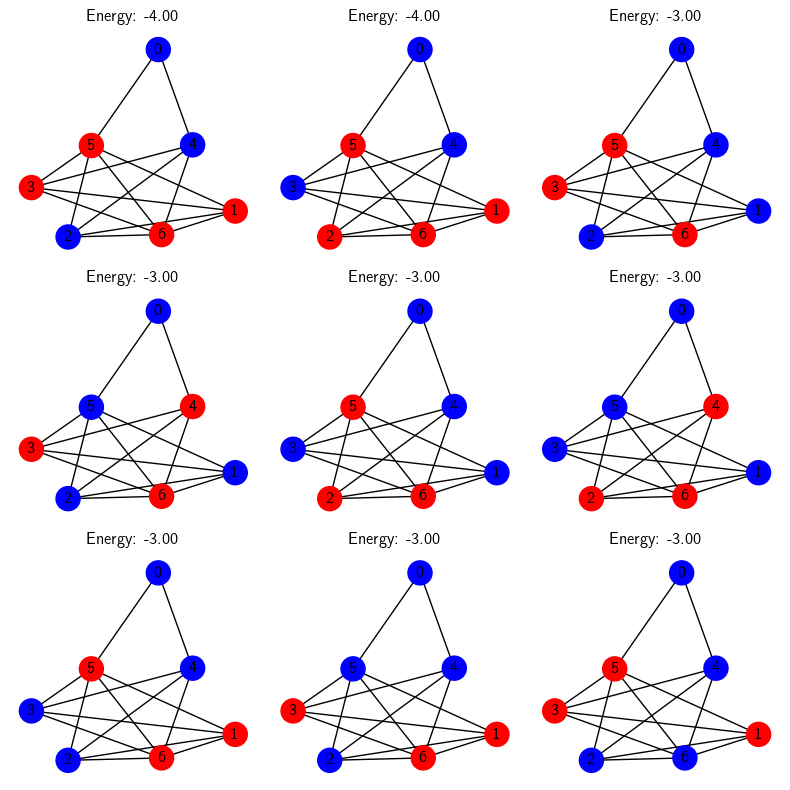

Pulse integral: 3.141199932599


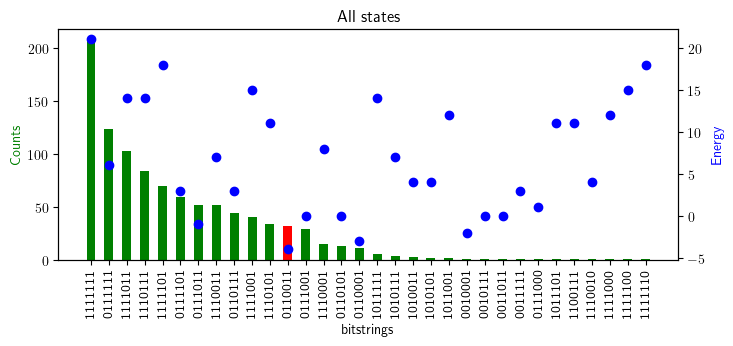

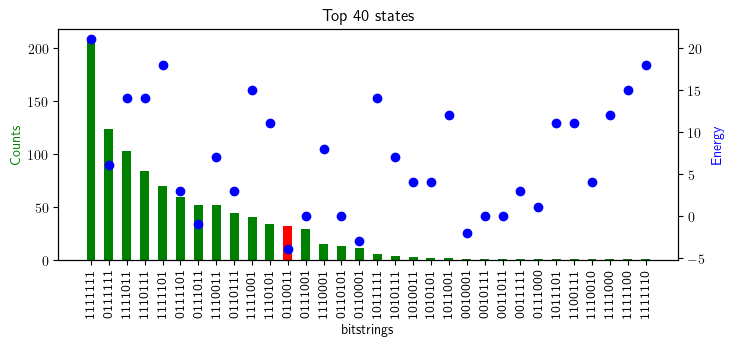

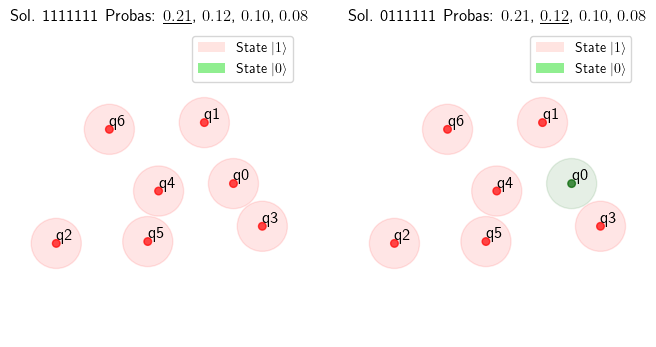

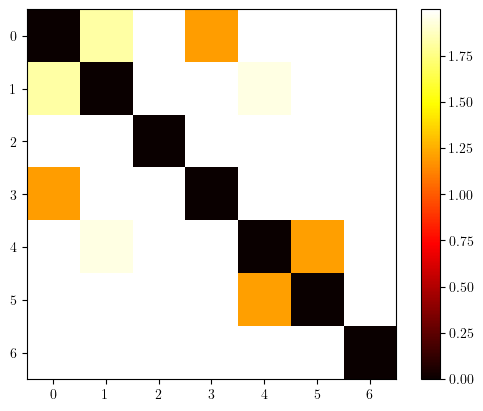

In [11]:
graph = gnm_random_graph(7, 14, seed=1338)
Q = max_clique_qubo(graph, A=1.0, B=2.0)
solutions = solve_qubo_bruteforce(Q, n=10) # my function, just tries all combinations

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
pos = nx.spring_layout(graph, seed=42)

for idx, s in enumerate(solutions[:9]):
    row = idx // 3
    col = idx % 3
    
    color_map = []
    for node in graph:
        if s[0][node] == 1:
            color_map.append('red')
        else:
            color_map.append('blue')
            
    nx.draw(graph, node_color=color_map, with_labels=True, 
            ax=axs[row, col], pos=pos)
    axs[row, col].set_title(f"Energy: {s[1]:.2f}")

plt.suptitle("Clique solutions (Brute-force)", fontsize=16)
plt.tight_layout()
plt.show()

# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 4.
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=True)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
delta_i = -0.1
delta_f = -delta_i
T = 8_000  # time in ns
Omega = 1.5 * np.pi * 1000. / T
count_dict = anneal(reg, Omega, delta_i, delta_f, T, device=MockDevice)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:5]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=None)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.title("All states")
plt.show()

plot_distribution(count_dict, solutions_strs, show=False, n_max_states=40)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:40], res_vals[:40], c="blue")
plt.title("Top 40 states")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff, cmap='hot', interpolation='nearest')
plt.colorbar()

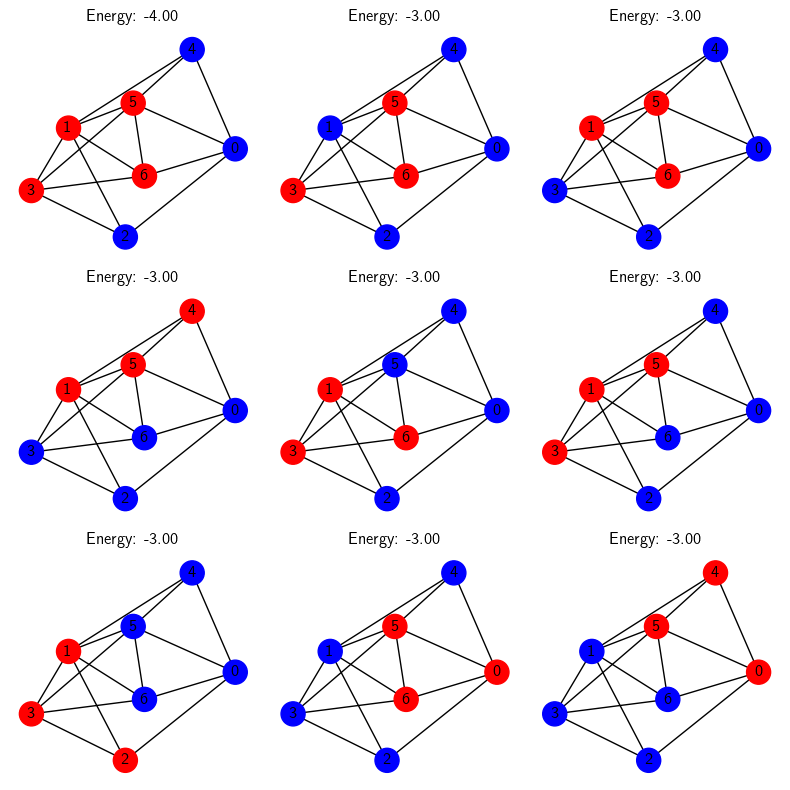

Pulse integral: 3.141435576691


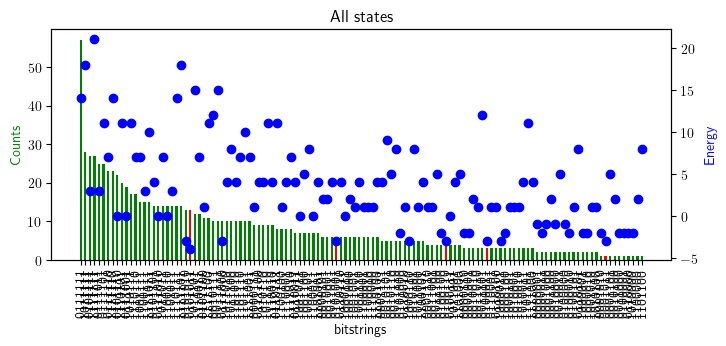

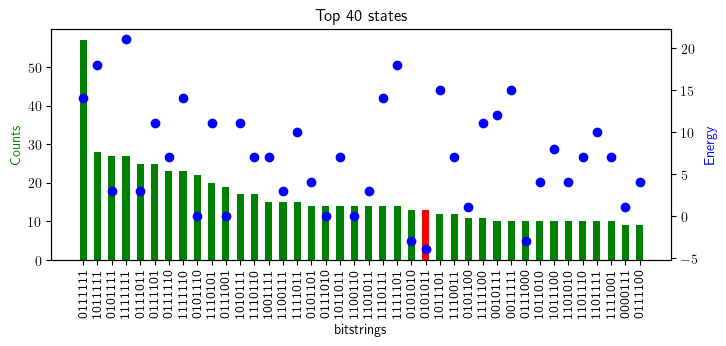

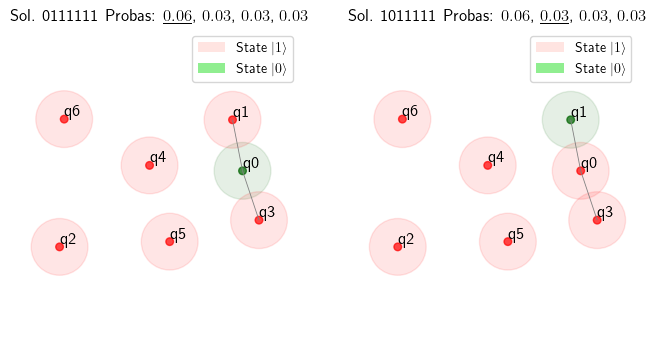

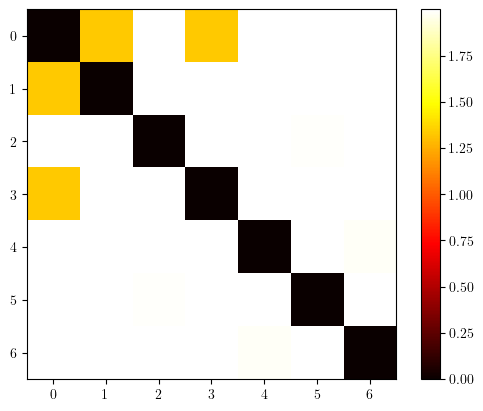

In [12]:
graph = gnm_random_graph(7, 14, seed=1339)
Q = max_clique_qubo(graph, A=1.0, B=2.0)
solutions = solve_qubo_bruteforce(Q, n=10) # my function, just tries all combinations

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
pos = nx.spring_layout(graph, seed=42)

for idx, s in enumerate(solutions[:9]):
    row = idx // 3
    col = idx % 3
    
    color_map = []
    for node in graph:
        if s[0][node] == 1:
            color_map.append('red')
        else:
            color_map.append('blue')
            
    nx.draw(graph, node_color=color_map, with_labels=True, 
            ax=axs[row, col], pos=pos)
    axs[row, col].set_title(f"Energy: {s[1]:.2f}")

plt.suptitle("Clique solutions (Brute-force)", fontsize=16)
plt.tight_layout()
plt.show()

# divide Q by a value to not have atoms touch (in Rydberg blockade)
# does not change the solution
normalization = 5.0
coords, res = get_register_embedding(Q/normalization, seed=4, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=True)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
delta_i = -1.0
delta_f = -delta_i
T = 20_000  # time in ns
Omega = 1.5 * np.pi * 1000. / T
count_dict = anneal(reg, Omega, delta_i, delta_f, T, device=MockDevice)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:5]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=None)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
plt.title("All states")
plt.show()

plot_distribution(count_dict, solutions_strs, show=False, n_max_states=40)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:40], res_vals[:40], c="blue")
plt.title("Top 40 states")
plt.show()
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff, cmap='hot', interpolation='nearest')
plt.colorbar()

# Graph Partitioning

In [13]:
from qubovert.problems import GraphPartitioning
from qubovert.utils import solve_qubo_bruteforce as qubo_solver

from source.qubovert_custom import problem_to_qubo_matrix

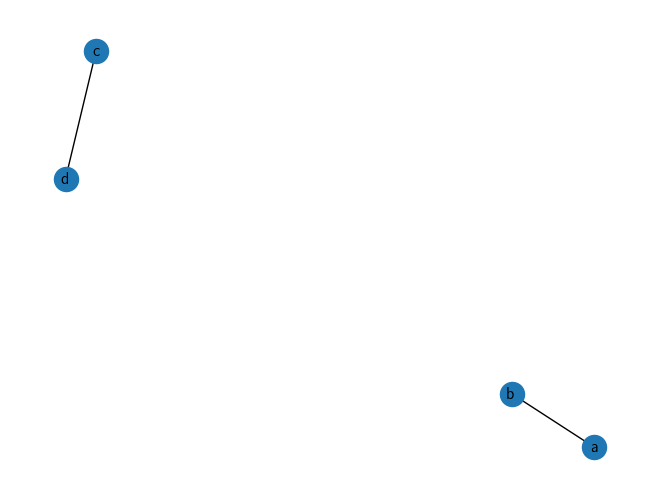

In [15]:
edges = {("a", "b"), ("c", "d")}
problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

In [28]:
Q = problem_to_qubo_matrix(problem)
matprint(Q)
solutions = solve_qubo_bruteforce(Q, n=3)
solutions

-2   2   2   0  
 2  -2   0   2  
 2   0  -2   2  
 0   2   2  -2  


[(array([0, 1, 1, 0]), -4.0),
 (array([1, 0, 0, 1]), -4.0),
 (array([0, 0, 0, 1]), -2.0)]

/home/bigbogo/Documents/Projects/PulserLearn/QUBOExploration/../source/qubo.py:91: UserWarning: Relative differences between the QUBO matrix and the new matrix are too high: 1.999871972690799
  warnings.warn(f"Relative differences between the QUBO matrix and the new matrix are too high: {np.max(rel_diff)}")
/home/bigbogo/Documents/Projects/PulserLearn/QUBOExploration/../source/qubo.py:92: UserWarning: rel_diff: 
[[0.00000000e+00 1.99979438e+00 1.99624043e+00 1.98916875e+00]
 [1.99979438e+00 0.00000000e+00 1.99987197e+00 5.70901093e-04]
 [1.99624043e+00 1.99987197e+00 0.00000000e+00 5.66832708e-04]
 [1.98916875e+00 5.70901093e-04 5.66832708e-04 0.00000000e+00]]
  warnings.warn(f"rel_diff: \n{rel_diff}")


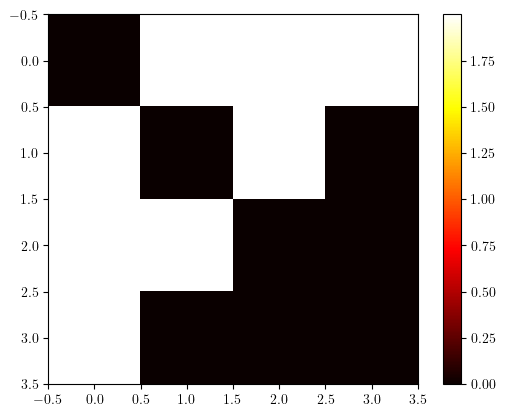

In [35]:
coords, res = get_register_embedding(Q, seed=6, lossf="rmse", device=DigitalAnalogDevice)
Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff, cmap='hot', interpolation='nearest')
plt.colorbar()

Pulse integral: 3.14096427386


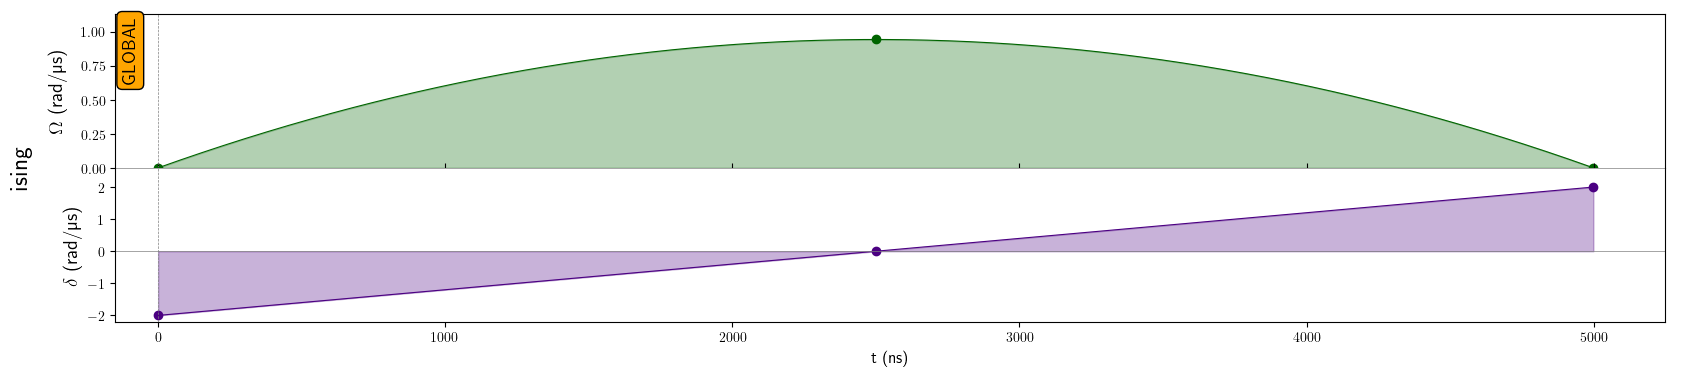

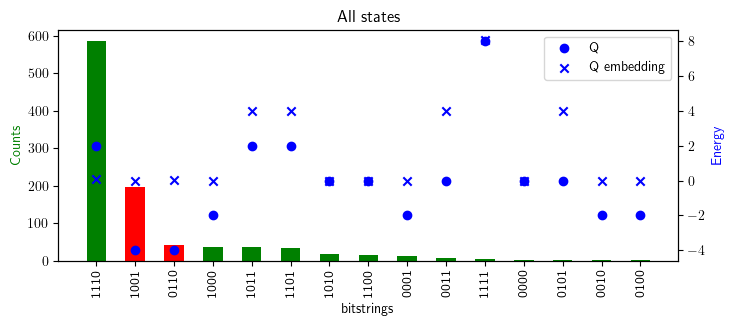

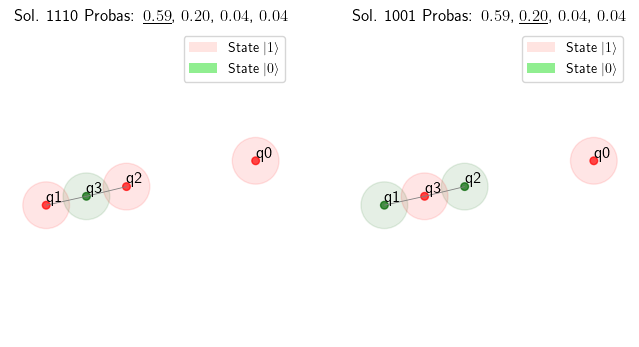

In [37]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
delta_i = -2  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
Omega = 1.5 * np.pi * 1000. / T  # Rabi frequency in MHz
count_dict = anneal(reg, Omega, delta_i, delta_f, T, draw_pulse=True)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
res_vals_embedding = np.einsum("ij,jk,ik->i", res_states, Q_embedding, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=None)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue", marker="o", label="Q")
plt.scatter(np.arange(len(res_vals)), res_vals_embedding, c="blue", marker="x", label="Q embedding")
plt.legend()
plt.title("All states")
plt.show()
# plot_distribution(count_dict, solutions_strs)
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

## More Graphs

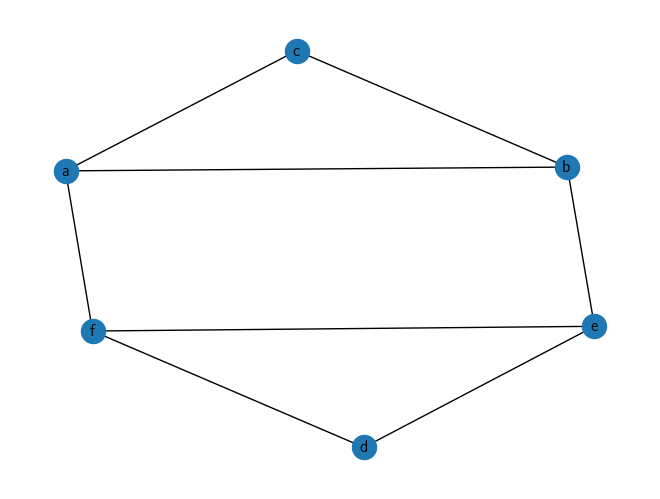

      -1       0.5  0.333333  0.333333       0.5  0.333333  
     0.5  -1.08333       0.5       0.5  0.333333  0.333333  
0.333333       0.5        -1  0.333333  0.333333       0.5  
0.333333       0.5  0.333333  -1.08333       0.5       0.5  
     0.5  0.333333  0.333333       0.5        -1  0.333333  
0.333333  0.333333       0.5       0.5  0.333333        -1  


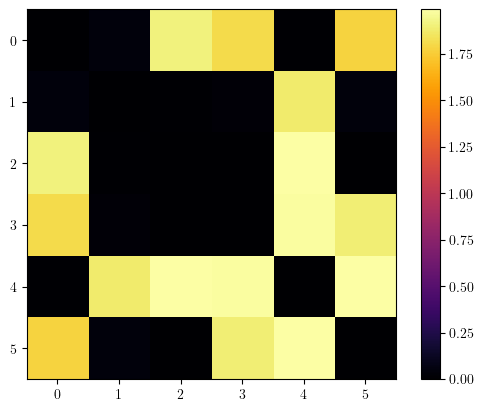

Pulse integral: 3.14096427386


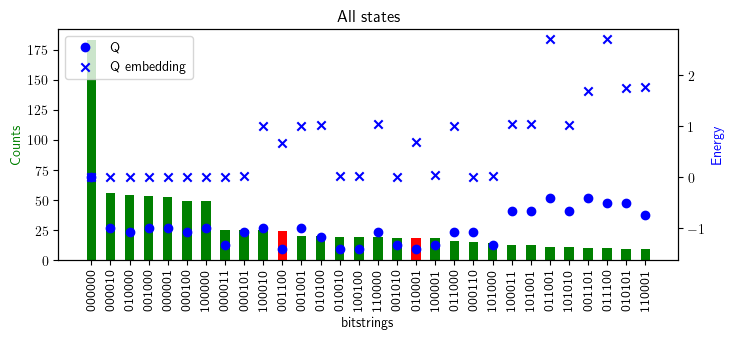

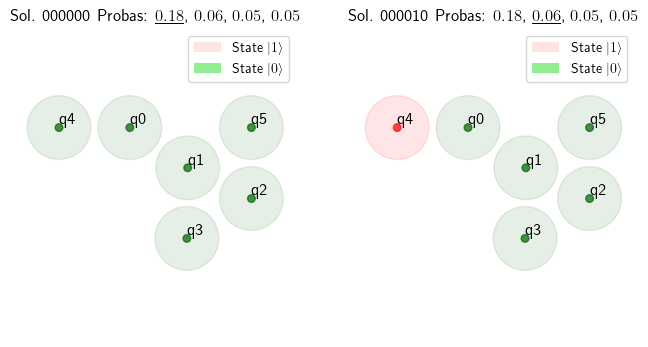

In [143]:
edges = {
    ("a", "b"),
    ("a", "c"),
    ("b", "c"),
    ("d", "e"),
    ("f", "e"),
    ("d", "f"),
    ("a", "f"),
    ("b", "e"),
    }
problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

Q = problem_to_qubo_matrix(problem)
normalization = 12.0
Q = Q / normalization
matprint(Q)
solutions = solve_qubo_bruteforce(Q, n=3)

coords, res = get_register_embedding(Q, seed=7, lossf="rmse", device=DigitalAnalogDevice, ignore_warnings=True)
Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff,interpolation='nearest', cmap="inferno")
plt.colorbar()
plt.show()

qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
delta_i = -12.0  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
Omega = 1.5 * np.pi * 1000. / T  # Rabi frequency in MHz
count_dict = anneal(reg, Omega, delta_i, delta_f, T, draw_pulse=False)

# plotting
n_hist_draw = 30
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
res_vals_embedding = np.einsum("ij,jk,ik->i", res_states, Q_embedding, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=n_hist_draw)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals[:n_hist_draw], c="blue", marker="o", label="Q")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals_embedding[:n_hist_draw], c="blue", marker="x", label="Q embedding")
plt.legend()
plt.title("All states")
plt.show()
# plot_distribution(count_dict, solutions_strs)
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

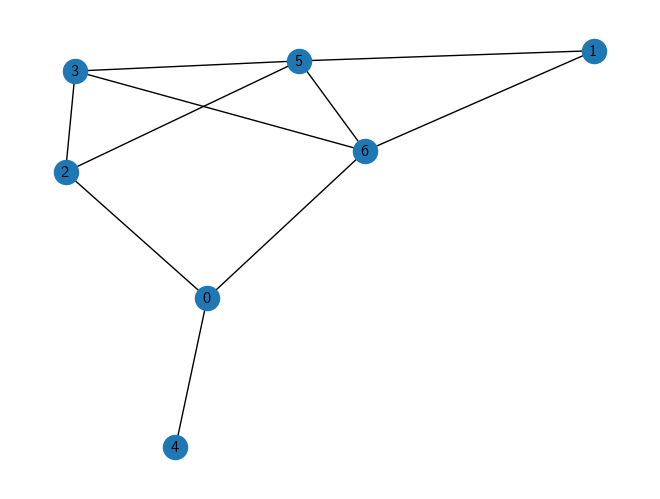

-17    5    5    5    7    7    5  
  5  -17    5    7    5    7    5  
  5    5  -18    7    5    7    7  
  5    7    7  -18    5    5    7  
  7    5    5    5  -18    7    7  
  7    7    7    5    7  -20    7  
  5    5    7    7    7    7  -19  


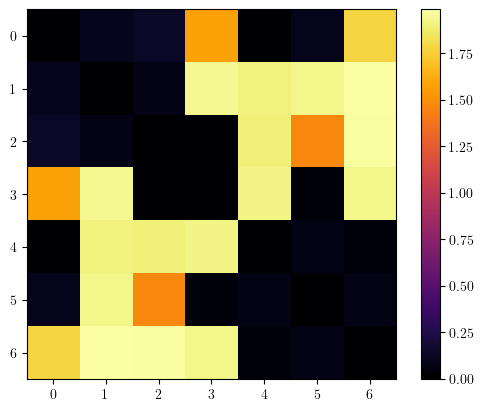

Pulse integral: 3.14096427386


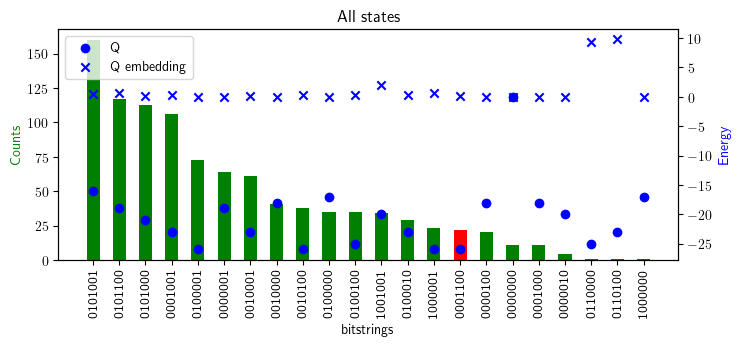

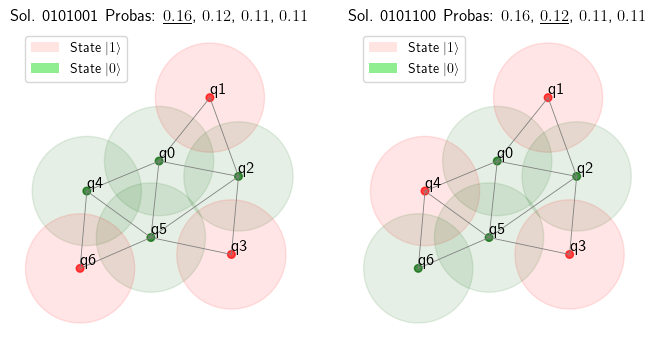

In [118]:
# random graph
g = gnm_random_graph(7, 10, seed=1337)
edges = dict(g.edges)
edges = {(str(i), str(j)) for i, j in edges}

problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

Q = problem_to_qubo_matrix(problem)
normalization = 1.0
Q = Q / normalization
matprint(Q)
solutions = solve_qubo_bruteforce(Q, n=3)

coords, res = get_register_embedding(Q, seed=7, lossf="rmse", device=DigitalAnalogDevice, ignore_warnings=True)
Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff,interpolation='nearest', cmap="inferno")
plt.colorbar()
plt.show()

qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
delta_i = -1.8  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
Omega = 1.5 * np.pi * 1000. / T  # Rabi frequency in MHz
count_dict = anneal(reg, Omega, delta_i, delta_f, T, draw_pulse=False)

# plotting
n_hist_draw = 30
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
res_vals_embedding = np.einsum("ij,jk,ik->i", res_states, Q_embedding, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=n_hist_draw)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals[:n_hist_draw], c="blue", marker="o", label="Q")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals_embedding[:n_hist_draw], c="blue", marker="x", label="Q embedding")
plt.legend()
plt.title("All states")
plt.show()
# plot_distribution(count_dict, solutions_strs)
draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

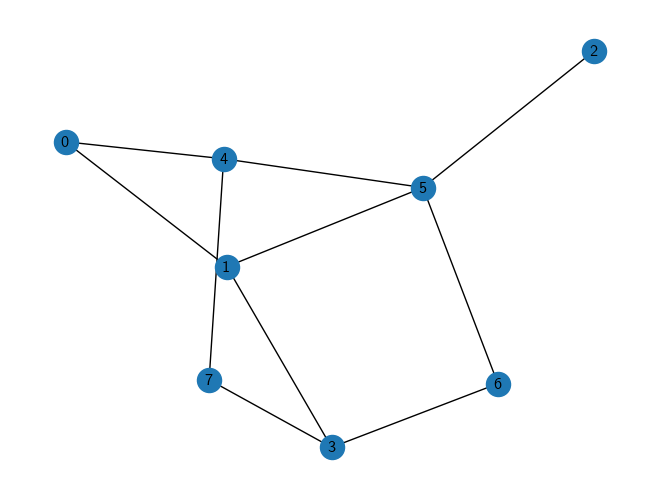

-26    8    8    6    8    8    6    8  
  8  -26    6    6    8    8    8    8  
  8    6  -24    8    8    6    6    6  
  6    6    8  -25    8    8    8    6  
  8    8    8    8  -26    8    6    6  
  8    8    6    8    8  -27    8    8  
  6    8    6    8    6    8  -25    8  
  8    8    6    6    6    8    8  -25  


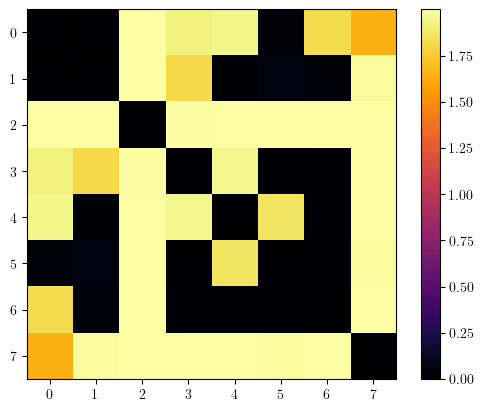

Pulse integral: 3.14096427386


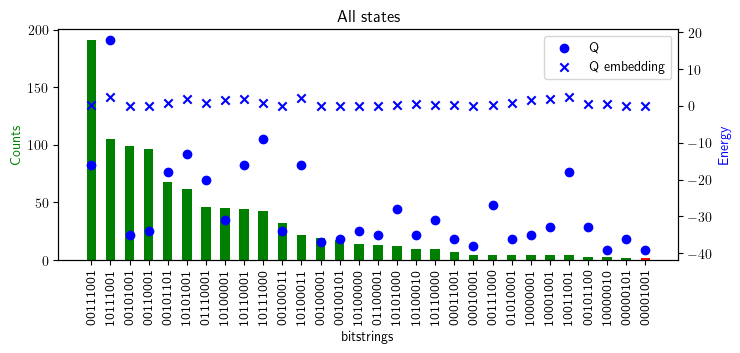

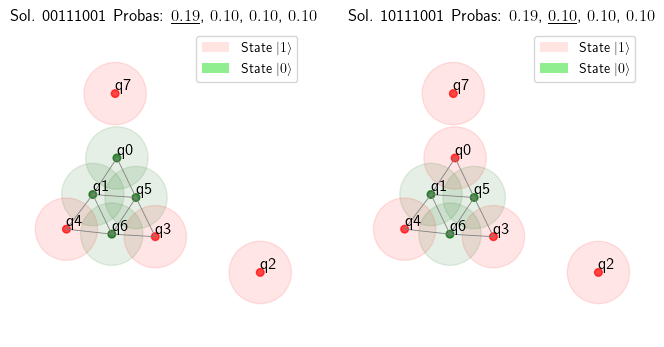

In [119]:
# random graph
g = gnm_random_graph(8, 10, seed=1337)
edges = dict(g.edges)
edges = {(str(i), str(j)) for i, j in edges}

problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

Q = problem_to_qubo_matrix(problem)
normalization = 1.0
Q = Q / normalization
matprint(Q)
solutions = solve_qubo_bruteforce(Q, n=3)

coords, res = get_register_embedding(Q, seed=7, lossf="rmse", device=DigitalAnalogDevice, ignore_warnings=True)
Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff,interpolation='nearest', cmap="inferno")
plt.colorbar()
plt.show()

qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
delta_i = -1.8  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
Omega = 1.5 * np.pi * 1000. / T  # Rabi frequency in MHz
count_dict = anneal(reg, Omega, delta_i, delta_f, T, draw_pulse=False)

# plotting
n_hist_draw = 30
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
res_vals_embedding = np.einsum("ij,jk,ik->i", res_states, Q_embedding, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=n_hist_draw)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals[:n_hist_draw], c="blue", marker="o", label="Q")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals_embedding[:n_hist_draw], c="blue", marker="x", label="Q embedding")
plt.legend()
plt.title("All states")
plt.show()
# plot_distribution(count_dict, solutions_strs)

draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

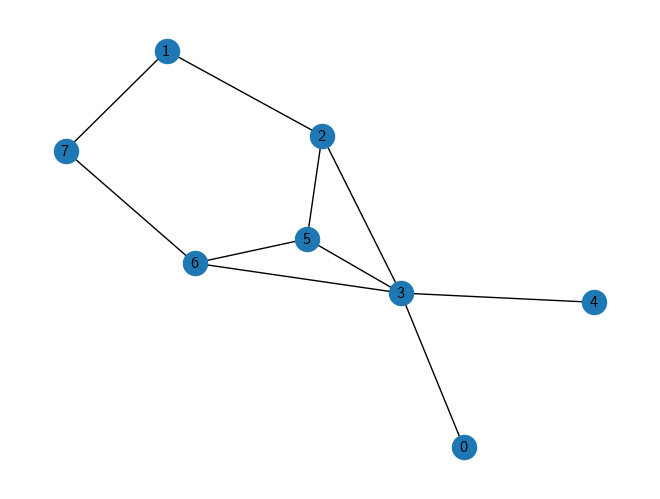

-26    6    8    8    8    8    8    6  
  6  -25    6    6    8    8    8    8  
  8    6  -25    6    8    6    8    8  
  8    6    6  -23    6    6    6    8  
  8    8    8    6  -27    8    8    8  
  8    8    6    6    8  -25    8    6  
  8    8    8    6    8    8  -27    8  
  6    8    8    8    8    6    8  -26  


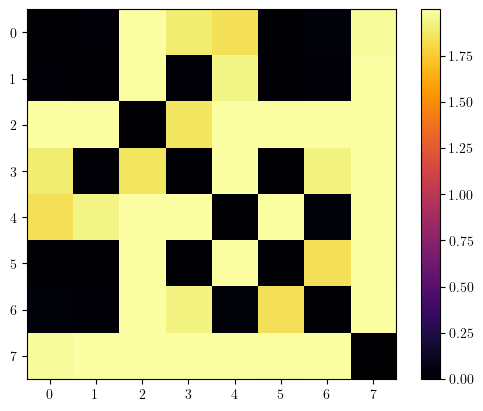

Pulse integral: 3.14096427386


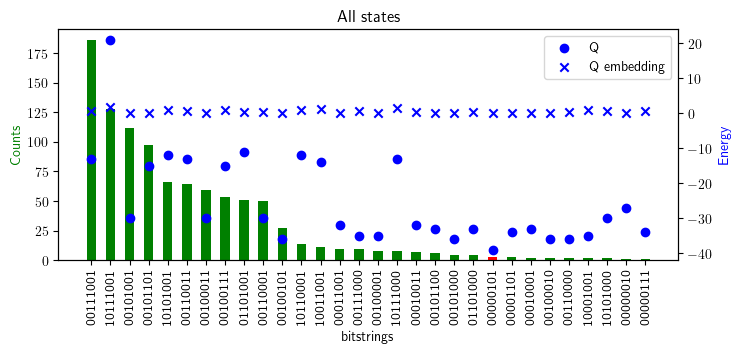

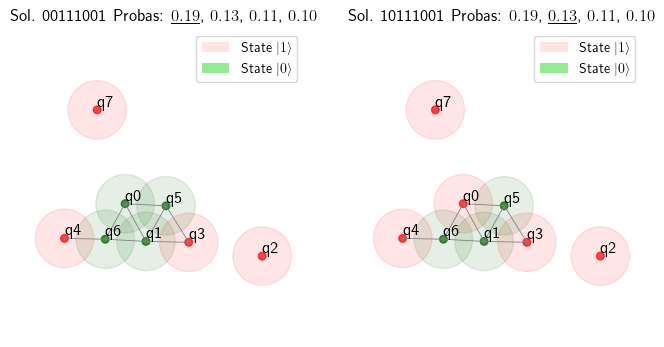

In [125]:
# random graph
g = gnm_random_graph(8, 10, seed=1339)
edges = dict(g.edges)
edges = {(str(i), str(j)) for i, j in edges}

problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

Q = problem_to_qubo_matrix(problem)
normalization = 1.0
Q = Q / normalization
matprint(Q)
solutions = solve_qubo_bruteforce(Q, n=3)

coords, res = get_register_embedding(Q, seed=7, lossf="rmse", device=DigitalAnalogDevice, ignore_warnings=True)
Q_embedding = get_Q_from_coords(coords)
Q_diff = 2 * np.abs(Q - Q_embedding) / (Q + Q_embedding + 1e-10)
np.fill_diagonal(Q_diff, 0)
# plot the matrix with 0 -> white, large -> red
plt.imshow(Q_diff,interpolation='nearest', cmap="inferno")
plt.colorbar()
plt.show()

qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
delta_i = -1.8  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
Omega = 1.5 * np.pi * 1000. / T  # Rabi frequency in MHz
count_dict = anneal(reg, Omega, delta_i, delta_f, T, draw_pulse=False)

# plotting
n_hist_draw = 30
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
res_vals_embedding = np.einsum("ij,jk,ik->i", res_states, Q_embedding, res_states)
plot_distribution(count_dict, solutions_strs, show=False, n_max_states=n_hist_draw)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals[:n_hist_draw], c="blue", marker="o", label="Q")
plt.scatter(np.arange(len(res_vals))[:n_hist_draw], res_vals_embedding[:n_hist_draw], c="blue", marker="x", label="Q embedding")
plt.legend()
plt.title("All states")
plt.show()
# plot_distribution(count_dict, solutions_strs)

draw_solutions(reg, count_dict, n=2, device=MockDevice, draw_graph=True, Omega=Omega)

# Graph Coloring